https://www.kaggle.com/code/elvisesp/time-series-analysis-using-fractional-differencing

# Time series analysis using fractional differencing

In [6]:
import numpy as np
import pandas as pd

import random

import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import adfuller

jtplot.style(figsize=(15, 9))

In [2]:
amd = pd.read_csv('../data/AMD_2002-01-01_2022-12-31_1d.csv', index_col=[0], parse_dates=True)
amd.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-12-31,16.490000,16.500000,15.850000,15.860000,3396500,0,0
2002-01-02,16.280001,16.410000,15.950000,16.389999,4475400,0,0
2002-01-03,16.719999,19.650000,16.719999,19.370001,14836600,0,0
2002-01-04,19.900000,20.200001,19.120001,20.000000,14737700,0,0
2002-01-07,20.450001,20.600000,19.530001,19.980000,9822300,0,0


<AxesSubplot:xlabel='Date'>

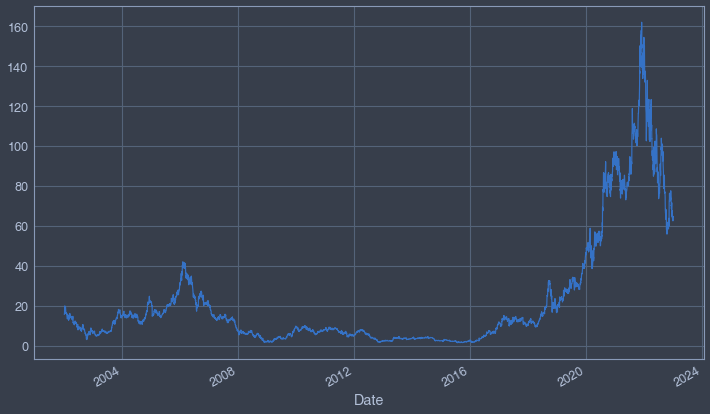

In [6]:
amd['Close'].plot()

In [3]:
adftest = adfuller(amd['Close'])
print(f'ADF Statistic: {adftest[0]}')
print(f'ADF p-value: {adftest[1]}')

ADF Statistic: -1.0373045850128149
ADF p-value: 0.7394163952575636


Text(0.5, 1.0, 'AMD Log Close')

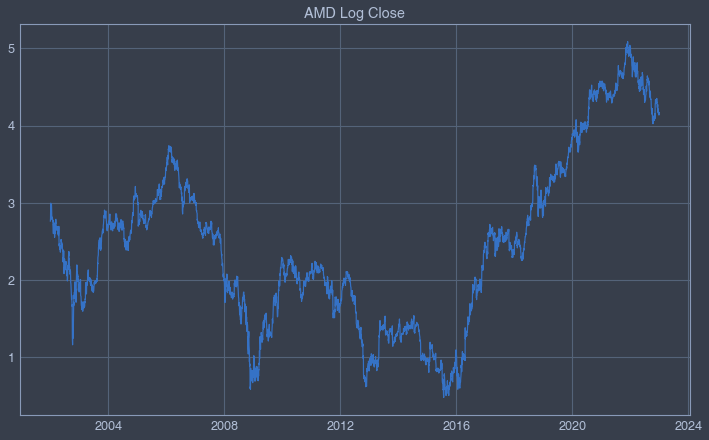

In [7]:
amd_log = pd.DataFrame(np.log(amd['Close']), index=amd.index)
plt.plot(amd_log)
plt.title('AMD Log Close')

In [8]:
adftest = adfuller(amd_log['Close'])
print(f'ADF Statistic: {adftest[0]}')
print(f'ADF p-value: {adftest[1]}')

ADF Statistic: -0.8424139241916929
ADF p-value: 0.8063448253120798


In [9]:
amd['returns'] = np.log(amd['Close'].div(amd['Close'].shift(1)))
amd_log['log_returns'] = np.log(amd_log['Close'].div(amd_log['Close'].shift(1)))

Text(0.5, 1.0, 'Log Returns')

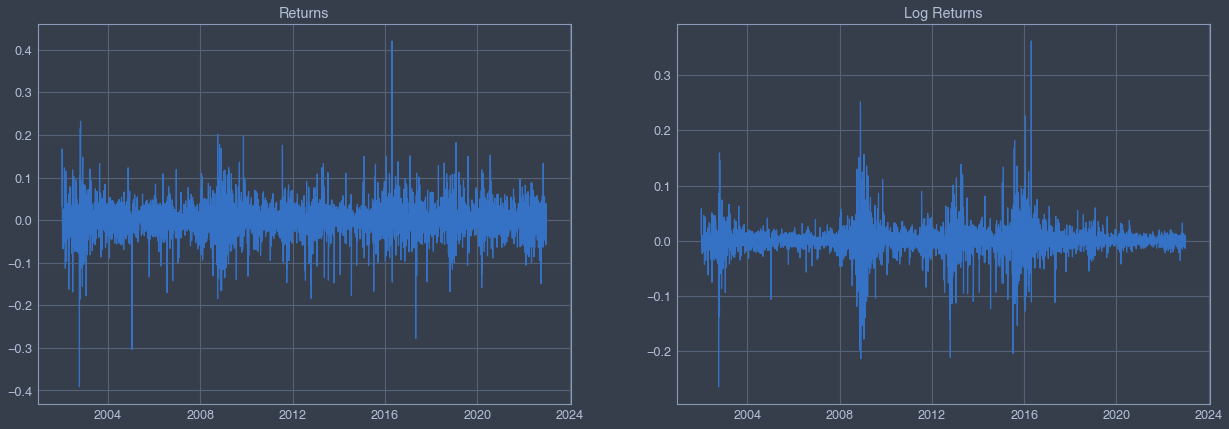

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))

ax[0].plot(amd['returns'])
ax[0].set_title('Returns')

ax[1].plot(amd_log['log_returns'])
ax[1].set_title('Log Returns')

In [10]:
adftest_ret=adfuller(amd['returns'].dropna())
print(f'Returns ADF Statistic: {adftest_ret[0]}')
print(f'Returns ADF p-value: {adftest_ret[1]}\n')

adftest_lret=adfuller(amd_log['log_returns'].dropna())
print(f'Log-Returns ADF Statistic: {adftest_lret[0]}')
print(f'Log-Returns ADF p-value: {adftest_lret[1]}')

Returns ADF Statistic: -26.710391010448046
Returns ADF p-value: 0.0

Log-Returns ADF Statistic: -12.987016353986732
Log-Returns ADF p-value: 2.8642277643341548e-24


## Traditional Differencing

In [11]:
amd['diff'] = amd['Close'] - amd['Close'].shift(1)
amd_log['log_diff'] = amd_log['Close'] - amd_log['Close'].shift(1)

Text(0.5, 1.0, 'Log Diff')

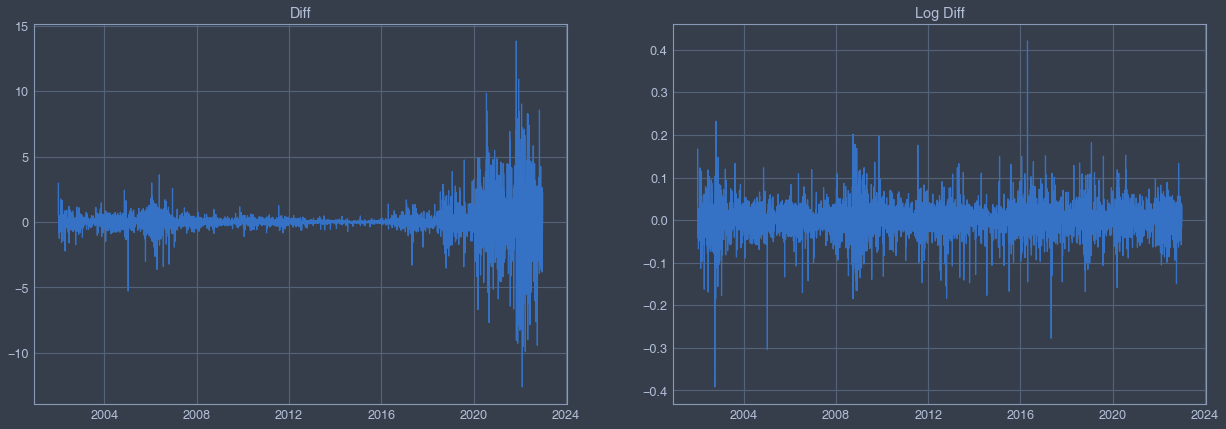

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))

ax[0].plot(amd['diff'])
ax[0].set_title('Diff')

ax[1].plot(amd_log['log_diff'])
ax[1].set_title('Log Diff')

In [12]:
adftest_ret=adfuller(amd['diff'].dropna())
print(f'Returns ADF Statistic: {adftest_ret[0]}')
print(f'Returns ADF p-value: {adftest_ret[1]}\n')

adftest_lret=adfuller(amd_log['log_diff'].dropna())
print(f'Log-Returns ADF Statistic: {adftest_lret[0]}')
print(f'Log-Returns ADF p-value: {adftest_lret[1]}')

Returns ADF Statistic: -13.062927788350976
Returns ADF p-value: 2.0297938798239147e-24

Log-Returns ADF Statistic: -26.710391010448163
Log-Returns ADF p-value: 0.0


## Fractional Differencing

In [13]:
# https://gist.github.com/skuttruf/fb82807ab0400fba51c344313eb43466
def getWeights(d, lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w = [1]
    for k in range(1,lags):
        w.append(-w[-1]*((d - k + 1))/k)
    w = np.array(w).reshape(-1, 1) 
    return w


def plotWeights(dRange, lags, numberPlots):
    weights = pd.DataFrame(np.zeros((lags, numberPlots)))
    interval = np.linspace(dRange[0], dRange[1], numberPlots)
    
    for i, diff_order in enumerate(interval):
        weights[i] = getWeights(diff_order, lags)
        
    weights.columns = [round(x, 2) for x in interval]
    
    fig = weights.plot(figsize=(15, 6))
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')


def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients
    weights = getWeights(order, lag_cutoff)
    res = 0
    
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
        
    return res[lag_cutoff:]


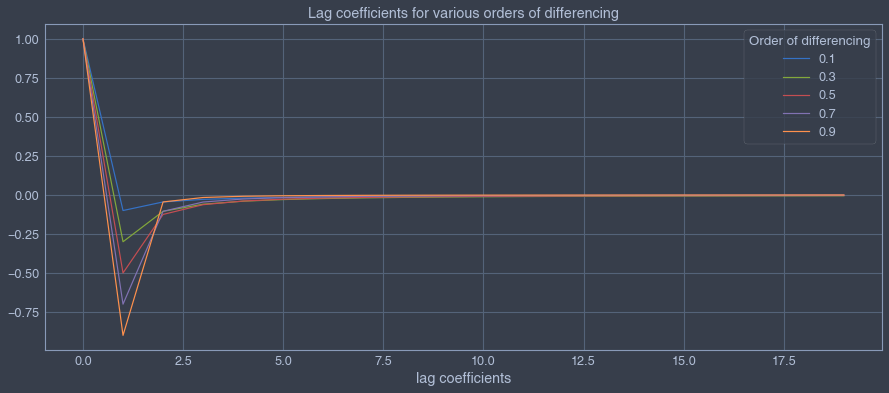

In [14]:
plotWeights([0.1, 0.9], 20, 5)

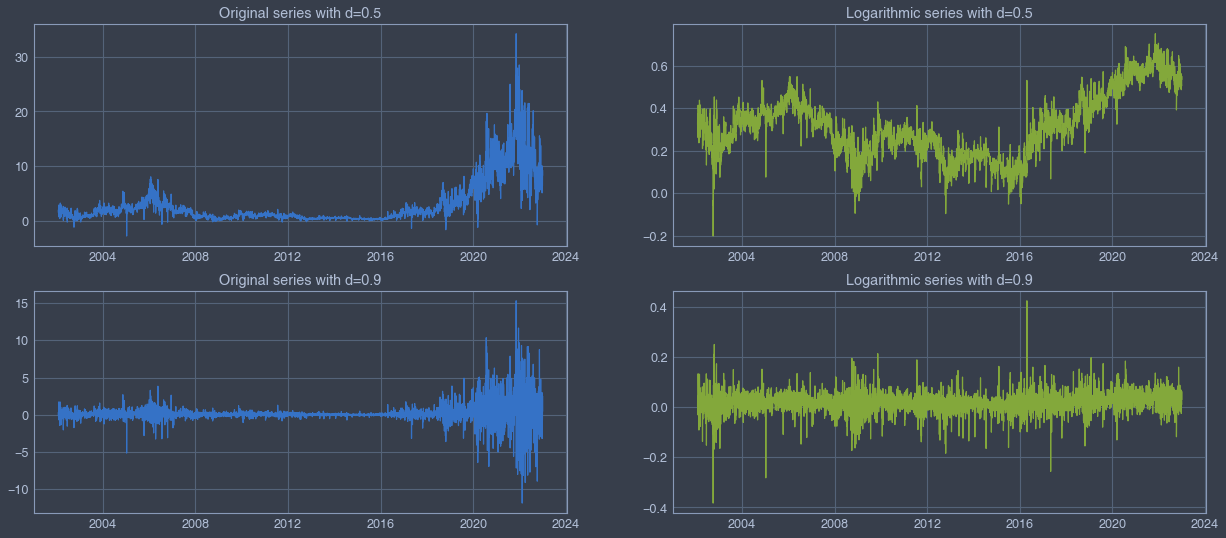

In [18]:
differences = [0.5, 0.9]
fig, axs = plt.subplots(len(differences), 2, figsize=(21, 8))

for i in range(0,len(differences)):
    axs[i,0].plot(ts_differencing(amd['Close'], differences[i], 20))
    axs[i,0].set_title('Original series with d='+str(differences[i]))
    axs[i,1].plot(ts_differencing(amd_log['Close'], differences[i], 20), 'g')
    axs[i,1].set_title('Logarithmic series with d='+str(differences[i]))
    plt.subplots_adjust(bottom=0.03)
    